In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf 
from tensorflow.keras.layers import Activation,Dense,BatchNormalization,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os 
import itertools
import shutil
import pathlib
import glob
from pathlib import Path

import warnings
from matplotlib import pyplot as plt 
import random
%matplotlib inline
warnings.simplefilter(action = 'ignore',category= FutureWarning)

2021-12-10 06:51:29.448301: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
print(len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

1


2021-12-10 06:51:31.900609: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-10 06:51:31.905948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-10 06:51:31.972401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 06:51:31.972599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-12-10 06:51:31.972633: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-10 06:51:32.004518: I tensorflow/stream_executor/platform/de

In [123]:
import sys
from PIL import Image , ImageOps
sys.modules['Image'] = Image 

# data directory
data_dir = Path('/home/t/Deeplearn/code/cat_and_dog/train/')
lists = ['cat','dog']
rand_image = f'/home/t/Deeplearn/code/cat_and_dog/train/{random.choice(lists)}.{random.randint(1,12000)}.jpg'
display(rand_image)


'/home/t/Deeplearn/code/cat_and_dog/train/dog.39.jpg'

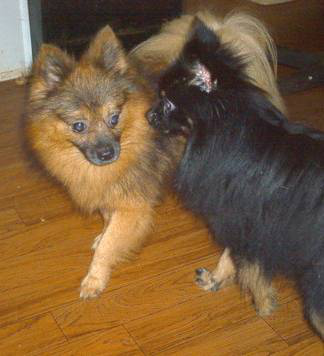

In [124]:
scr_image = Image.open(rand_image)
display(scr_image)

In [125]:
## check the dimension 
np.array(scr_image).shape

(356, 324, 3)

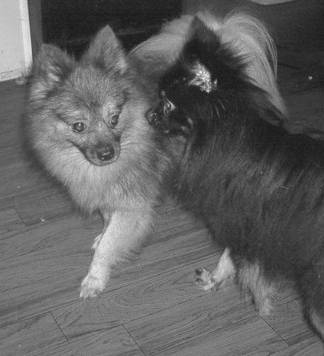

In [127]:
## turning to greyscale to reduce the dimension
grey = ImageOps.grayscale(scr_image)
display(grey)
#still a cat

In [128]:
 # checking the dimension again
np.array(grey).shape

(356, 324)

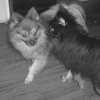

In [129]:
resized_grey = grey.resize(size = (100,100))
display(resized_grey)
# still a cat

In [130]:
## Flattening the image

cat = np.ravel(resized_grey)
cat

array([192, 191, 192, ..., 111, 113, 108], dtype=uint8)

In [131]:
# normalize the data
cat.max()
cat = cat/255

In [132]:
cat

array([0.75294118, 0.74901961, 0.75294118, ..., 0.43529412, 0.44313725,
       0.42352941])

In [133]:
## creating function to convert image to array

def to_array(path:str) -> np.array:
    img = Image.open(path)
    img = ImageOps.grayscale(img)
    img = img.resize(size = (100,100))
    img = np.ravel(img)/255
    return img

In [142]:
test_image = to_array(f'{data_dir}/cat.{random.randint(1,1500)}.jpg')
test_image.reshape(100,100)*255

array([[140., 142., 138., ..., 157., 150., 160.],
       [138., 142., 141., ..., 163., 156., 164.],
       [139., 141., 142., ..., 173., 167., 163.],
       ...,
       [122., 132., 134., ..., 162., 156., 149.],
       [115., 135., 132., ..., 158., 153., 147.],
       [109., 138., 134., ..., 156., 148., 145.]])

In [143]:
# Converting from array to Image

def to_image(array):
    
    img = Image.fromarray(np.uint8(array.reshape(100,100)*255))
    return display(img)

In [144]:
def cat_or_dog(image):
    if 'cat' in image:
        clas = 1
        
    else:
        clas = 0
    return clas      

In [145]:

cat_or_dog(rand_image)


1

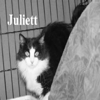

In [147]:
to_image(test_image)

In [19]:
# ## process the whole folder with dogs and cats images

# def process_folder(path: str):
#     processed = []
#     for image in os.listdir(path):
        
#         try:
#             processed.append([to_array(image),cat_or_dog(image)])
#             print('appended', image)
#         except:
#             continue
#     processed = pd.DataFrame(processed)
#     return processed

In [20]:
## creating the dataframe
names = os.listdir(data_dir)
paths = [os.path.join(data_dir,name) for name in names]

data = pd.DataFrame(paths,columns=['path'])
data 

classes = list(map(lambda x:(x.split('/')[-1]).split('.')[0],data['path']))

data['label'] = classes

data.head()

,path,label
0,/home/t/Deeplearn/code/cat_and_dog/train/cat.4...,cat
1,/home/t/Deeplearn/code/cat_and_dog/train/dog.5...,dog
2,/home/t/Deeplearn/code/cat_and_dog/train/dog.1...,dog
3,/home/t/Deeplearn/code/cat_and_dog/train/dog.3...,dog
4,/home/t/Deeplearn/code/cat_and_dog/train/dog.7...,dog


In [21]:
from sklearn.model_selection import train_test_split
train_data , test_data = train_test_split(data,test_size = .1, random_state = 2)

train_data.shape , test_data.shape

((22500, 2), (2500, 2))

In [22]:
train_data

,path,label
19467,/home/t/Deeplearn/code/cat_and_dog/train/cat.1...,cat
14395,/home/t/Deeplearn/code/cat_and_dog/train/cat.1...,cat
15733,/home/t/Deeplearn/code/cat_and_dog/train/cat.6...,cat
7188,/home/t/Deeplearn/code/cat_and_dog/train/cat.8...,cat
14698,/home/t/Deeplearn/code/cat_and_dog/train/dog.1...,dog
...,...,...
18898,/home/t/Deeplearn/code/cat_and_dog/train/cat.5...,cat
11798,/home/t/Deeplearn/code/cat_and_dog/train/dog.7...,dog
6637,/home/t/Deeplearn/code/cat_and_dog/train/dog.1...,dog
2575,/home/t/Deeplearn/code/cat_and_dog/train/dog.1...,dog


In [23]:
## Load the Image data

train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range = 0.2,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255
)

In [72]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_data[:10000],
    x_col = 'path',
    y_col = 'label',
    target_size = (100,100),
    color_mode= 'rgb',
    class_mode= 'binary',
    shuffle = True
    , seed = 42,
    batch_size = 32,
    subset = 'training'
    
)

val_images = train_generator.flow_from_dataframe(
    x_col = 'path',
    y_col = 'label',
    dataframe = train_data[:10000],
    target_size = (100,100),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_data[:300],
    x_col = 'path',
    y_col = 'label',
    target_size = (100,100),
    color_mode = 'rgb',
    class_mode = 'binary',
    batch_size = 32
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [73]:
batch1 =train_images.next()


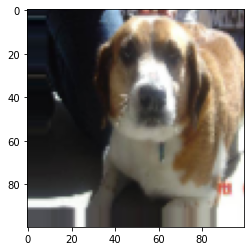

In [74]:
imag = np.array(batch1[0][i]*255,dtype = 'uint8')
plt.imshow(imag)

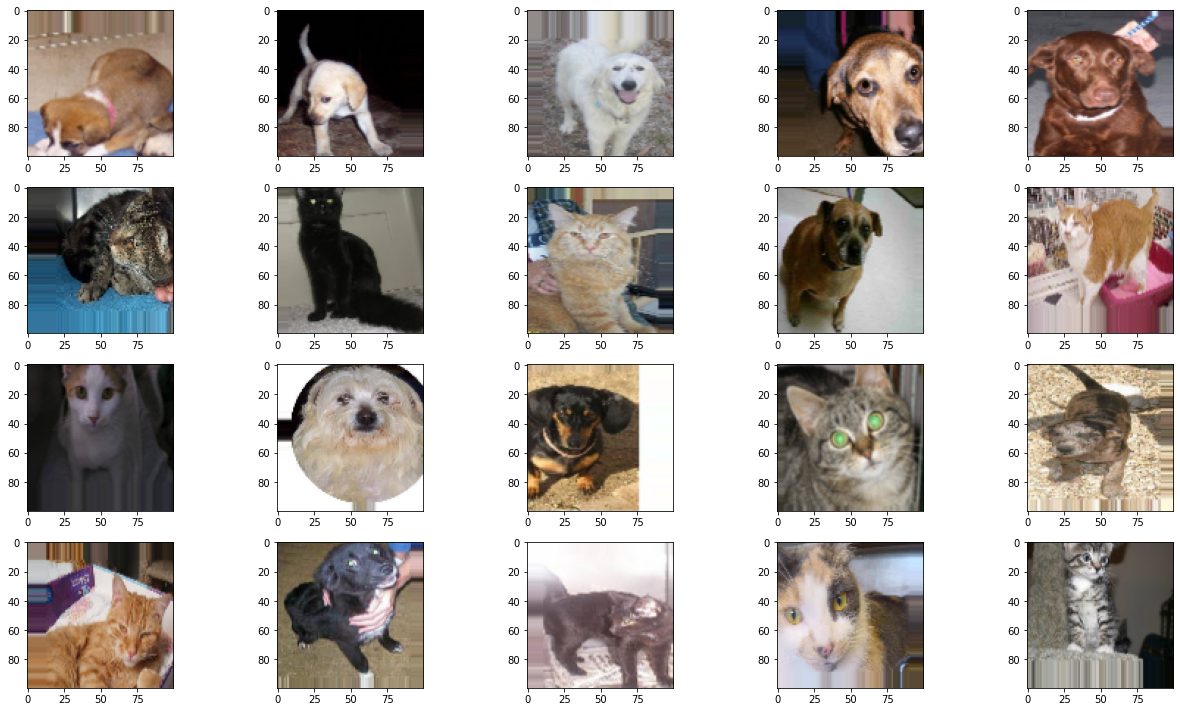

In [75]:
## visualize the data
batch1 = train_images.next()
def visualize(batch):
    plt.figure(figsize =(18,10))
    for i in range(20):
        plt.subplot(4,5,i+1)
        imag = np.array(batch[0][i]*255,dtype = 'uint8')
        plt.imshow(imag,cmap = 'gray')

    plt.tight_layout()
    plt.show()
    
visualize(batch1)

In [41]:
## Training

inputs = tf.keras.Input(shape=(100,100,1))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(30,activation = 'relu')(x)
x = tf.keras.layers.Dense(30,activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs,outputs = outputs)

model.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),
                 
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=10
                )]
)

Epoch 1/100
250/250 [==============================] - 27s 105ms/step - loss: 0.6925 - accuracy: 0.5224 - val_loss: 0.6828 - val_accuracy: 0.5925
Epoch 2/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6852 - accuracy: 0.5654 - val_loss: 0.6679 - val_accuracy: 0.5945
Epoch 3/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6727 - accuracy: 0.5921 - val_loss: 0.6600 - val_accuracy: 0.6185
Epoch 4/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6678 - accuracy: 0.5836 - val_loss: 0.6678 - val_accuracy: 0.5910
Epoch 5/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6666 - accuracy: 0.5976 - val_loss: 0.6622 - val_accuracy: 0.6065
Epoch 6/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6643 - accuracy: 0.6090 - val_loss: 0.6661 - val_accuracy: 0.5885
Epoch 7/100
250/250 [==============================] - 26s 104ms/step - loss: 0.6604 - accuracy: 0.6097 - val_loss: 0.6571 -

In [42]:
## Model with higher lr and dropout
## Training

inputs = tf.keras.Input(shape=(100,100,1))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(.3)(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(.3)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(30,activation = 'relu')(x)
x = tf.keras.layers.Dropout(.3)(x)

x = tf.keras.layers.Dense(30,activation = 'relu')(x)
x = tf.keras.layers.Dropout(.3)(x)

outputs = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)

model2 = tf.keras.Model(inputs = inputs,outputs = outputs)

model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history2 = model2.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True),
                 
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    patience=10
                )]
)

Epoch 1/100
250/250 [==============================] - 28s 109ms/step - loss: 0.6941 - accuracy: 0.4870 - val_loss: 0.6919 - val_accuracy: 0.5655
Epoch 2/100
250/250 [==============================] - 29s 116ms/step - loss: 0.6918 - accuracy: 0.5267 - val_loss: 0.6880 - val_accuracy: 0.5870
Epoch 3/100
250/250 [==============================] - 27s 107ms/step - loss: 0.6864 - accuracy: 0.5518 - val_loss: 0.6803 - val_accuracy: 0.5845
Epoch 4/100
250/250 [==============================] - 27s 108ms/step - loss: 0.6795 - accuracy: 0.5687 - val_loss: 0.6744 - val_accuracy: 0.5935
Epoch 5/100
250/250 [==============================] - 27s 108ms/step - loss: 0.6754 - accuracy: 0.5803 - val_loss: 0.6676 - val_accuracy: 0.5960
Epoch 6/100
250/250 [==============================] - 27s 108ms/step - loss: 0.6692 - accuracy: 0.5883 - val_loss: 0.6683 - val_accuracy: 0.5790
Epoch 7/100
250/250 [==============================] - 27s 108ms/step - loss: 0.6656 - accuracy: 0.5946 - val_loss: 0.6645 -

In [53]:
model.save('model.h5')
model2.save('model2.h5')

In [76]:
model1 = tf.keras.models.load_model('model.h5')
model1.summary()

2021-12-10 07:31:01.623871: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 07:31:01.624523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 07:31:01.624688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-12-10 07:31:01.624722: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library lib

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                990 

In [77]:
model2 = tf.keras.models.load_model('model2.h5')
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0   

In [ ]:
## MOdel3 

In [79]:
hist1 = pd.DataFrame(history.history)
hist2 = pd.DataFrame(history2.history)

# plt.figure(figsize = (16,7))
# plt.subplot(1,2,1)
# plt.plot(hist1)
# plt.title('Model1')
# plt.subplot(1,2,2)
# plt.plot(hist2)
# plt.title('Model2')

hist1.plot(title = 'Model1')
hist2.plot(title = 'Model2')


TypeError: no numeric data to plot